# 3. Parameter estimation

This notebook introduces the `Estimator` class and demonstrates it's functions for paramater estimation using the example of a simple batch model (see Notebook [1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb)). 

## 0. Import dependencies

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
import pandas as pd

## 1. Import the `SimpleBatch` FMU model

In [38]:
SimpleBatchModel = FmuModel(path=r'../tests/test_data/SimpleBatch.fmu')
print(f"Model parameters: \n {SimpleBatchModel.parameters}")
print(f"Model observables: \n {SimpleBatchModel.observables}")

Model parameters: 
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.2, 'Y_XS': 0.35, 'mu_max': 0.4}
Model observables: 
 ['S', 'X', 'der(S)', 'der(X)', 'mu']


## 2. Load experimental data & datastructure setup
In order to setup an `Experiment` datastructure (see [Notebook 2](2.%20Experimental%20data%20and%20error%20modeling.ipynb)), raw measurement data is loaded first. Here, the function `pandas.read_excel` is used to read the contents of an Excel sheet _SimpleBatch_Data.xlsx_, which contains artificial measurements for biomass concentration `X` $[g \cdot L^{-1}]$ and substrate concentration `S` $[g \cdot L^{-1}]$ over the duration of a batch cultivation.

In [32]:
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0,1))
data.head(11)

Time,X,S
h,g/L,g/L
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
0.5,0.268477,NaN
0.6,0.312500,NaN
0.7,0.150687,NaN
0.8,0.226870,NaN


Before creating an `Experiment` object by passing the created `DataFrame`, the multi-index must be removed. 

For this simple example no we assume the `Experiment`'s default `LinearErrorModel` to describe the noises of `Measurement`s (see Notebook [2. Experimental data and error modeling](2.%20Experimental%20data%20and%20error%20modeling.ipynb)). As the names of the columns in `data` directly correspond to the states in `SimpleBatchModel.observables` no `observation_mapping` must be defined.

In [33]:
# drop the multi-index header and show resulting dataframe
data.columns = data.columns.droplevel(1)
display(data)

# create an Experiment object
experiment = datatypes.Experiment(data) 

Time,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
...,...,...
9.6,4.885956,NaN
9.7,4.807351,NaN
9.8,5.167874,NaN
9.9,5.220779,NaN


To compare the unfitted model's precitions to experimental data, the `plot_simulation` function of the `visualization` submodule takes a keyword argument experiment.

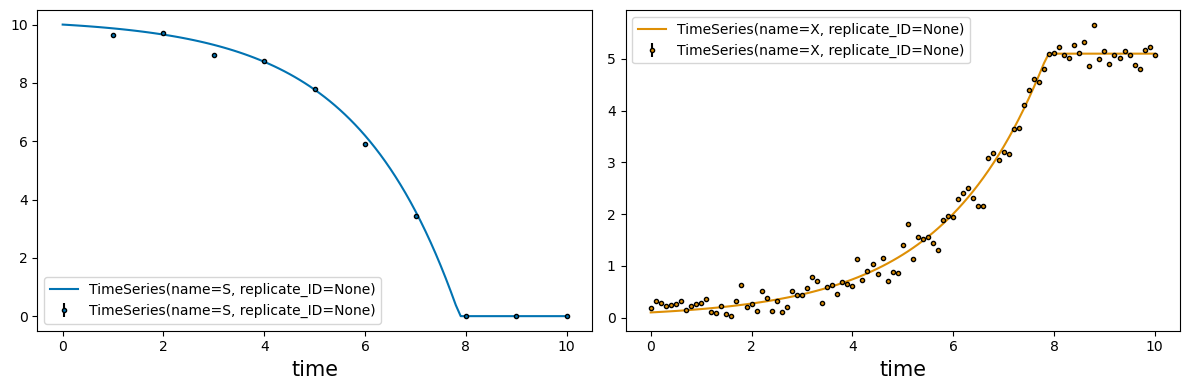

In [37]:
# compare simulation to data
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=0.1)
_ = visualization.plot_simulation(simulation=simulation, experiment=experiment, observe=['S', 'X'])

In [6]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

## The `Estimator` class

The `Estimator` class manages the processes of model fitting.

In [7]:
# Instantiating an Estimator object
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,        # anknowns and bounds
    data=experiment,      # experimental data
    t=[0, 10, 0.1],        # the timeframe for simulation,
    metric = 'SS'         # default Sum of squared residuals
)

## Optimization Algortithms
`Estim8` supports a variety of optimzation algorithms from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), [scikit-optimize](https://scikit-optimize.github.io/stable/) and [pygmo](https://esa.github.io/pygmo2/index.html). Is is higly recommended to check out their documentations, e.g. for the use of solver hyperparameters. 

###  scipy and scikit-optimize alogorithms and keys: 

| method key         | optimization function          | solver parallelization |
|-----------------|-----------------------------------|------------------------|
| local           | `scipy.optimize.minimize`         | ❌                  |
| de              | `scipy.optimize.differential_evolution` | ✅               |
| bh              | `scipy.optimize.basinhopping`     |❌                  |
| shgo            | `scipy.optimize.shgo`             |✅               |
| dual_annealing  | `scipy.optimize.dual_annealing`   |❌                  |
| gp              | `skopt.gp_minimize`               |✅               |



### Single core parameter estimation
Single core estimation supports all optimization functions from scipy and scikit-optimize listed above.

In [8]:
estimates, info = estimator.estimate(
    method='de',
    max_iter=1000,          # maximum number of iterations for the solver
    optimizer_kwargs={      # kewyword arguments to pass to the optimization function
        'disp': True
    }
)

differential_evolution step 1: f(x)= 13.792154038421678
differential_evolution step 2: f(x)= 4.70817304537562
differential_evolution step 3: f(x)= 4.70817304537562
differential_evolution step 4: f(x)= 4.669828236750312
differential_evolution step 5: f(x)= 3.964438095966657
differential_evolution step 6: f(x)= 3.964438095966657
differential_evolution step 7: f(x)= 3.964438095966657
differential_evolution step 8: f(x)= 3.964438095966657
differential_evolution step 9: f(x)= 3.964438095966657
differential_evolution step 10: f(x)= 3.9503203362603845
differential_evolution step 11: f(x)= 3.866704855909796
differential_evolution step 12: f(x)= 3.866704855909796
differential_evolution step 13: f(x)= 3.866704855909796
differential_evolution step 14: f(x)= 3.8517091408305184
differential_evolution step 15: f(x)= 3.8517091408305184
differential_evolution step 16: f(x)= 3.8517091408305184
differential_evolution step 17: f(x)= 3.8517091408305184
differential_evolution step 18: f(x)= 3.8517091408305

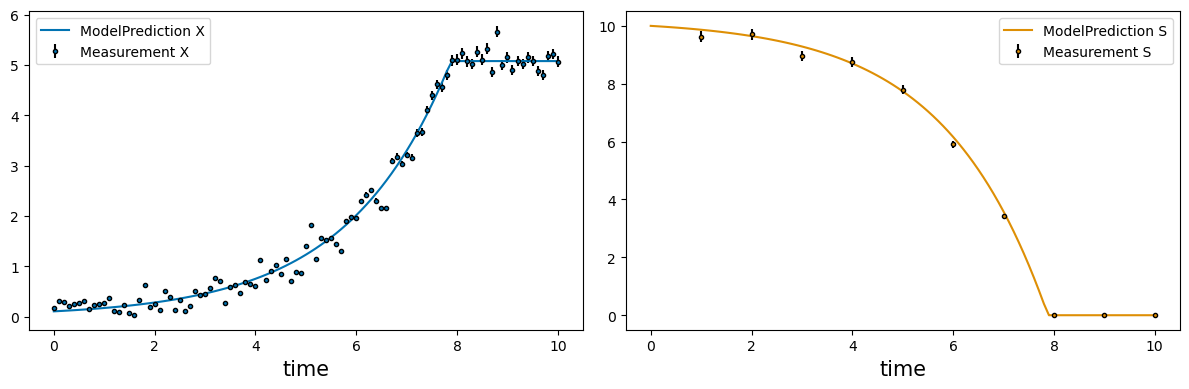

In [11]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

### Multicore parameter estimation


In [ ]:
estimates, info = estimator.estimate(
    method='de',
    max_iter=1000,          # maximum number of iterations for the solver,
    n_jobs = 4,             # process pool size of the solver algorithm
    optimizer_kwargs={      # kewyword arguments to pass to the optimization function
        'disp': True
    }
)

differential_evolution step 1: f(x)= 7.751351999181734
differential_evolution step 2: f(x)= 7.270714259948848
differential_evolution step 3: f(x)= 7.270714259948848
differential_evolution step 4: f(x)= 7.270714259948848
differential_evolution step 5: f(x)= 6.228413210924679
differential_evolution step 6: f(x)= 6.228413210924679
differential_evolution step 7: f(x)= 6.228413210924679
differential_evolution step 8: f(x)= 6.228413210924679
differential_evolution step 9: f(x)= 3.9518060730908804
differential_evolution step 10: f(x)= 3.9518060730908804
differential_evolution step 11: f(x)= 3.9518060730908804
differential_evolution step 12: f(x)= 3.9518060730908804
differential_evolution step 13: f(x)= 3.9518060730908804
differential_evolution step 14: f(x)= 3.9134117421117303
differential_evolution step 15: f(x)= 3.9134117421117303
differential_evolution step 16: f(x)= 3.9134117421117303
differential_evolution step 17: f(x)= 3.891135778049972
differential_evolution step 18: f(x)= 3.891135778

### pygmo

| method key                | algorithm                                         |
|------------------------|-----------------------------------------------------|
| scipy_optimize          | A wrapper around `scipy.optimize.minimize`          |
| de1220                 | Self-adaptive Differential Evolution, pygmo flavour (pDE) |
| bee_colony             | Artificial Bee Colony                               |
| gaco                   | Extended Ant Colony Optimization algorithm          |
| pso                    | Particle Swarm Optimization                         |
| sga                    | A Simple Genetic Algorithm                          |
| sea                    | (N+1)-ES simple evolutionary algorithm              |
| compass_search          | Compass Search                                      |
| gwo                    | Grey Wolf Optimizer (gwo)                           |
| cmaes                  | Covariance Matrix Evolutionary Strategy (CMA-ES)     |
| simulated_annealing     | Simulated Annealing (Corana’s version)              |
| nsga2                  | Non dominated Sorting Genetic Algorithm (NSGA-II)    |
| mbh                    | Monotonic Basin Hopping (generalized)               |
| ihs                    | Improved harmony search algorithm                   |
| xnes                   | Exponential Evolution Strategies                    |
| de                     | Differential Evolution                              |

For using `pygmo`'s Generalized Islands approach, pass a list of the solver algorithms. 

In [ ]:
estimates, info = estimator.estimate(
    method=['sga']*4,       # algorithms for islands
    n_jobs=4,               # process pool size of the solver algorithm
    max_iter=1,             # iterations
    optimizer_kwargs = {
        'n_evos': 10,       # evolutions per iteration, total evos = n_evos * max_iter
        'pop_size': 30,
    }
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.6s finished


>>> Created Island 1 using <pygmo.core.sga object at 0x000001E066904F30>
>>> Created Island 2 using <pygmo.core.sga object at 0x000001E066904430>
>>> Created Island 3 using <pygmo.core.sga object at 0x000001E066905E70>
>>> Created Island 4 using <pygmo.core.sga object at 0x000001E066907B30>


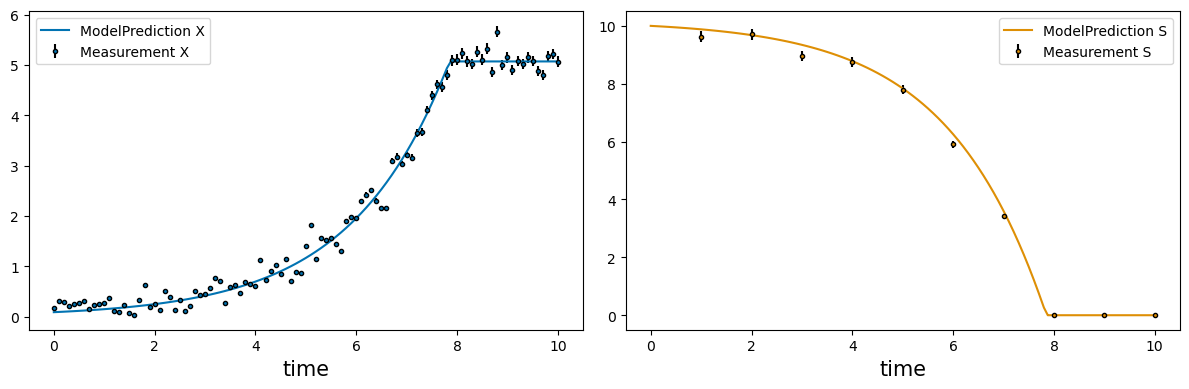

In [14]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)